# Importing and Pre-Processing the dataset

In [2]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\mediamill.csv")
df = df.drop(columns=['id'])

df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class92,Class93,Class94,Class95,Class96,Class97,Class98,Class99,Class100,Class101
0,0.380877,0.494079,0.540009,0.422926,0.158318,0.326975,0.390861,0.527121,0.254052,0.223731,...,0,0,0,0,0,0,0,0,0,0
1,0.508613,0.505837,0.437155,0.490723,0.262201,0.459610,0.393838,0.524006,0.370391,0.329424,...,0,0,0,0,0,0,0,0,0,0
2,0.449571,0.460490,0.453469,0.410779,0.231759,0.402147,0.349590,0.536456,0.318117,0.301615,...,0,0,0,0,0,0,0,0,0,0
3,0.416800,0.548996,0.520850,0.465410,0.181603,0.357255,0.389347,0.530189,0.290942,0.244521,...,0,0,0,0,0,0,0,0,0,0
4,0.501986,0.480820,0.435543,0.432002,0.250599,0.408353,0.357816,0.499186,0.353172,0.327622,...,0,0,0,0,0,0,0,0,0,0


# Visualizing the label distribution


<AxesSubplot:>

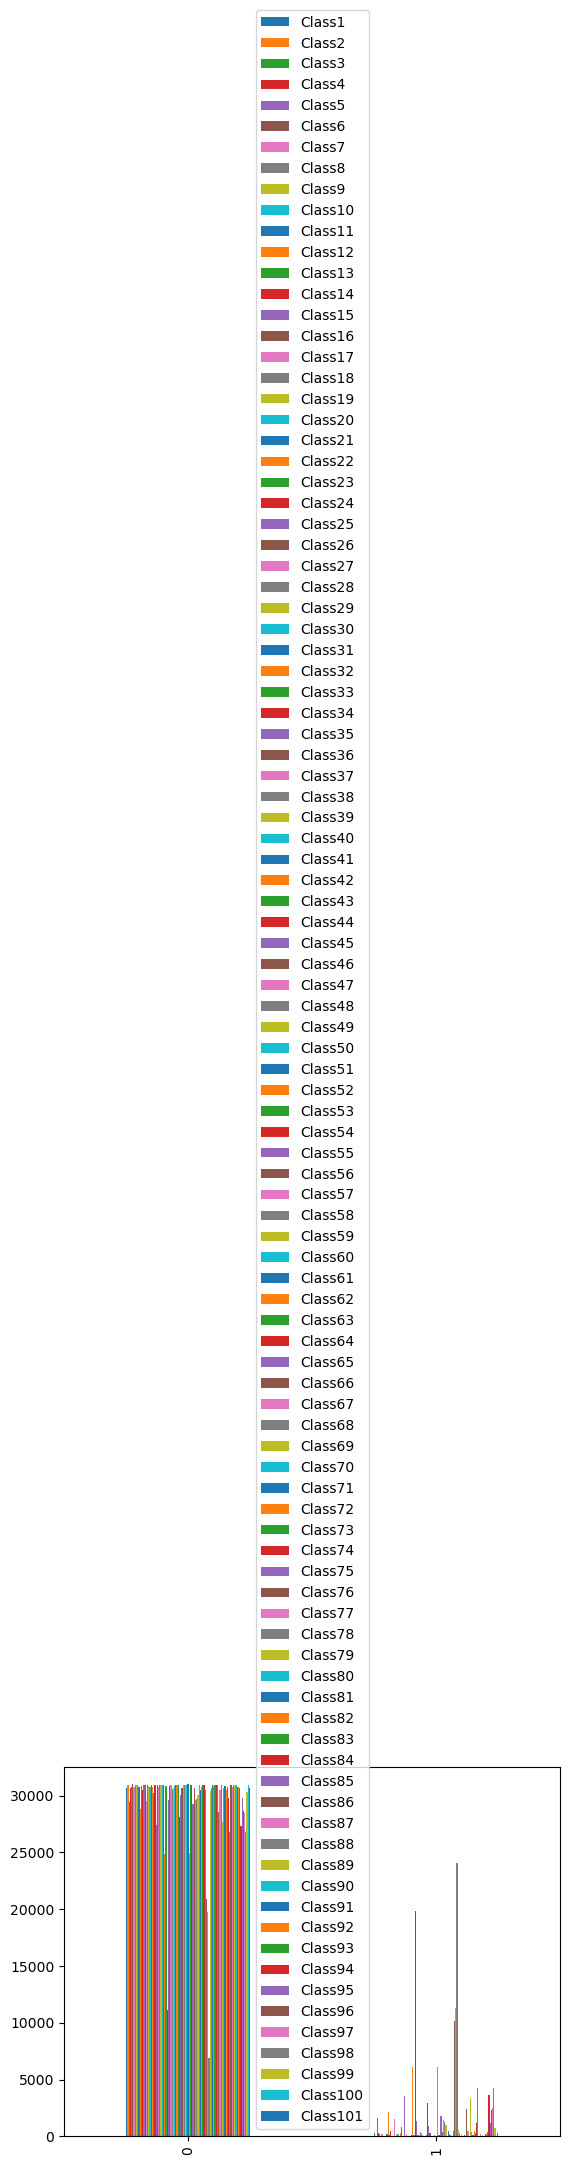

In [3]:
df1 = df[df.columns[120:]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

# MLSMOTE

In [4]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# Preparing training DataFrame

In [5]:
from sklearn.model_selection import train_test_split

X_df = df[df.columns[0:120]]
y_df = df[df.columns[120:]]

X = np.asarray(X_df)
y = np.asarray(y_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_traindf = pd.DataFrame(X_train)
y_traindf = pd.DataFrame(y_train)
df_train = pd.concat([X_traindf, y_traindf], axis=1)
df_train.columns = range(df_train.shape[1])
df_train.T.reset_index(drop=True).T

X_sub, y_sub = get_minority_samples(X_train, y_train) # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 8000, 5)  # Applying MLSMOTE to augment the dataframe

df_temp = pd.concat([X_res, y_res], axis=1)
df_temp.columns = range(df_temp.shape[1])
df_temp.T.reset_index(drop=True).T

df_train.reset_index(drop=True, inplace=True)
df_temp.reset_index(drop=True, inplace=True)
df_train = pd.concat([df_train, df_temp])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,211,212,213,214,215,216,217,218,219,220
0,0.531570,0.512514,0.438192,0.459889,0.266076,0.440385,0.373577,0.506067,0.386540,0.343472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.506746,0.501809,0.483229,0.363291,0.250370,0.389580,0.331052,0.493291,0.385969,0.344699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.481820,0.496846,0.493581,0.360696,0.222705,0.362627,0.327796,0.491080,0.344427,0.316578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.463086,0.493258,0.517857,0.367340,0.220785,0.372519,0.333346,0.525031,0.332488,0.305944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.361688,0.257228,0.256766,0.201577,0.339399,0.286383,0.186148,0.253572,0.369322,0.378553,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visualizing the resampled training labels

<AxesSubplot:>

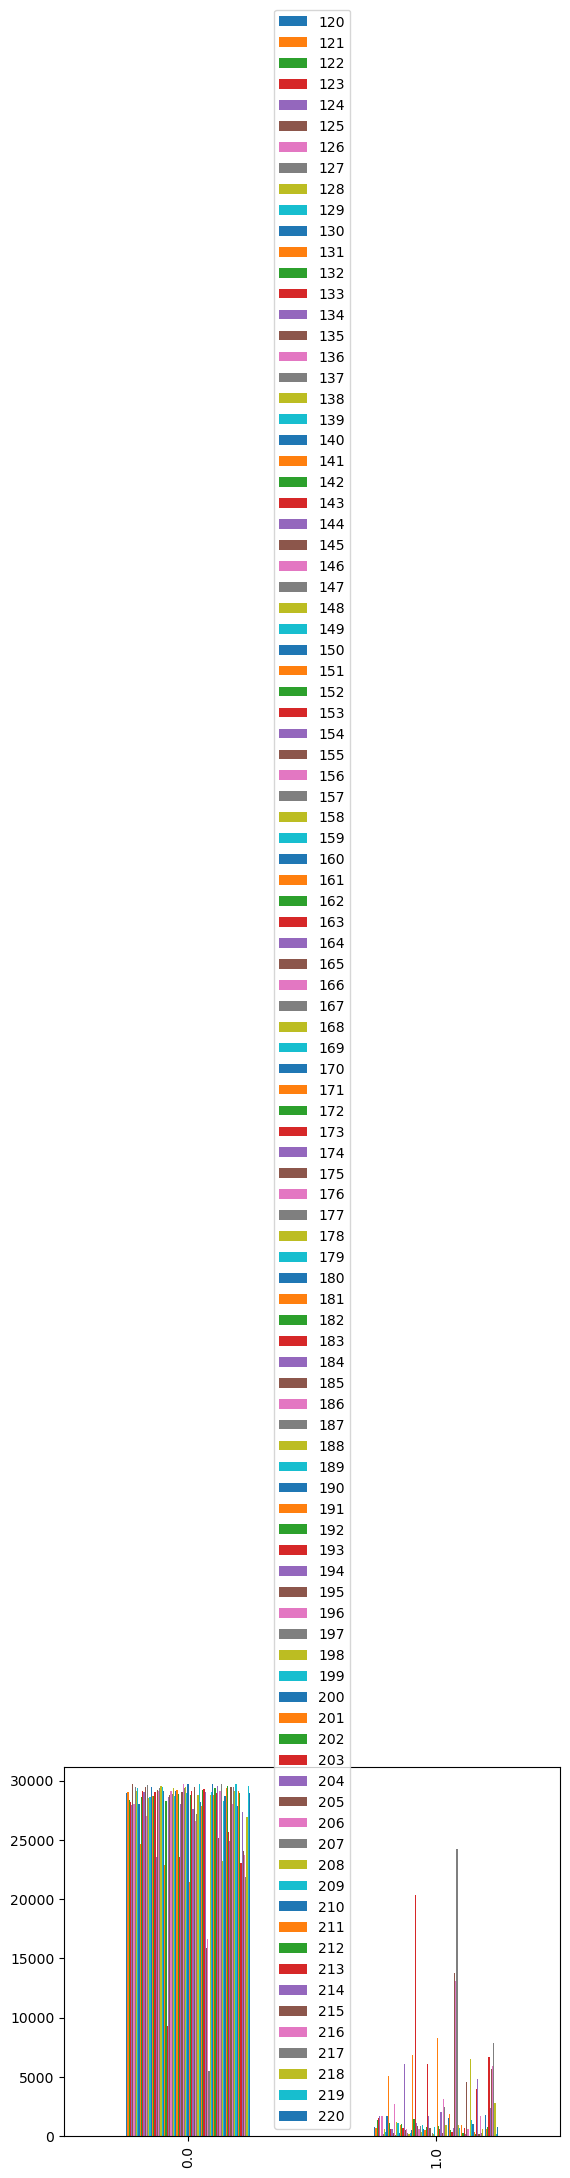

In [7]:
X_new = df_train[df_train.columns[0:120]]
y_new = df_train[df_train.columns[120:]]

df2 = y_new.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")